## Initialize colab environment
Ignore this cell in local execution

In [ ]:
import os
assert not os.getcwd().endswith('nightimaging24/demo'), "Looks like you're in the source dir already. This cell should be run only once"
!git clone https://github.com/createcolor/nightimaging24/ 
!pip install -r ./nightimaging24/requirements.txt
%cd nightimaging24/

## Imports and settings

In [ ]:
import sys
sys.path.append('..')

from pathlib import Path
from raw_prc_pipeline.pipeline_utils import get_visible_raw_image, get_metadata
from raw_prc_pipeline.pipeline import PipelineExecutor, RawProcessingPipelineDemo
import matplotlib.pyplot as plt
import matplotlib
import cv2
import numpy as np
from utils import fraction_from_json, json_read
from raw_prc_pipeline import expected_landscape_img_height, expected_landscape_img_width, expected_img_ext

: 

In [2]:
matplotlib.rcParams['figure.figsize'] = (20, 10)

## Parsing raw images and image metadata

In [4]:
png_path = Path('./data/test_huawei.png')

# parse raw img
raw_image = cv2.imread(str(png_path), cv2.IMREAD_UNCHANGED)
# parse metadata
metadata = json_read(png_path.with_suffix('.json'), object_hook=fraction_from_json)

## Initializing parameters of RawProcessingPipelineDemo

In [5]:
pipeline_params = {
    'tone_mapping': 'Flash', # options: Flash, Storm, Base, Linear, Drago, Mantiuk, Reinhard
    'illumination_estimation': 'gw', # ie algorithm, options: "gw", "wp", "sog", "iwp"
    'denoise_flg': True,
    'out_landscape_width': expected_landscape_img_width,
    'out_landscape_height': expected_landscape_img_height,
    "color_matrix": [  1.06835938, -0.29882812, -0.14257812, 
                      -0.43164062,  1.35546875,  0.05078125, 
                      -0.1015625,   0.24414062,  0.5859375]
}

pipeline_demo = RawProcessingPipelineDemo(**pipeline_params)

## Viewing raw image data after linearization
Raw image is one-channel. You may see squares due to Moiré pattern

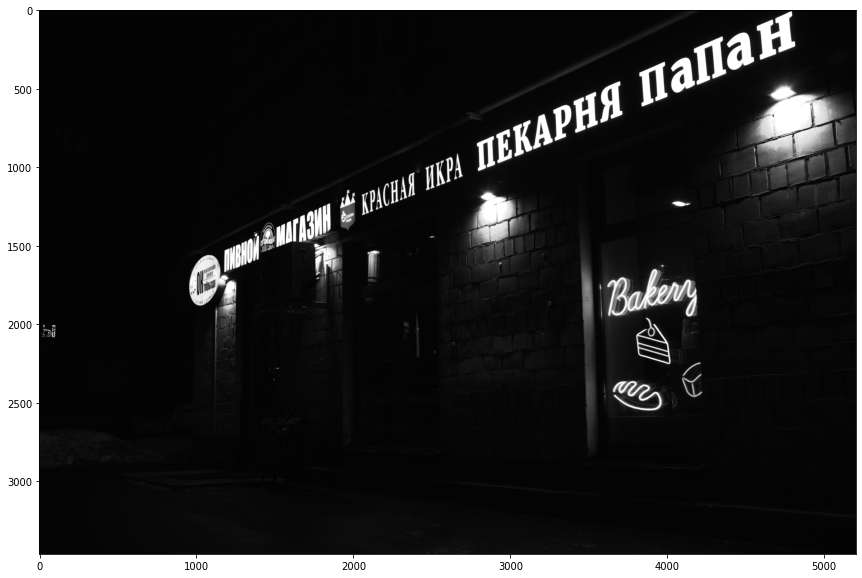

In [6]:
linearized_image = pipeline_demo.linearize_raw(raw_image, metadata)
plt.imshow(linearized_image, cmap='gray')

## Normalizing values

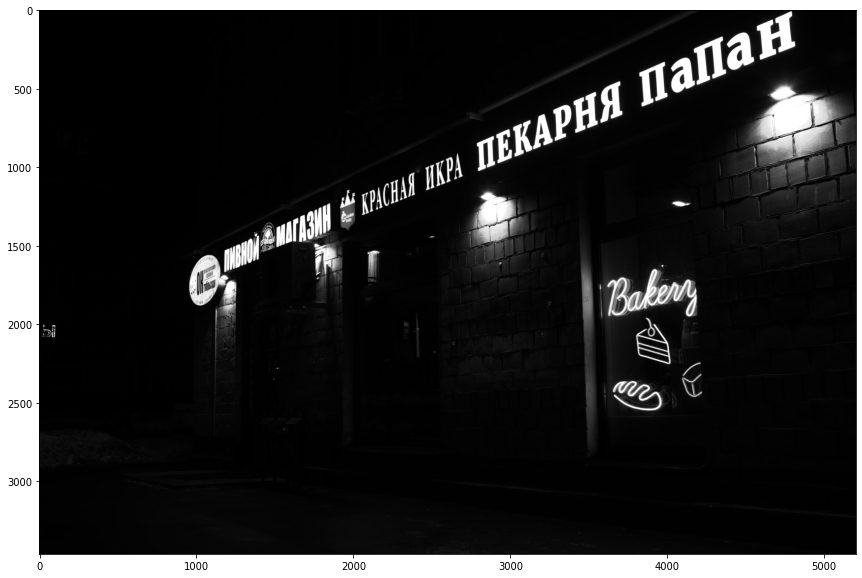

In [7]:
normalized_image = pipeline_demo.normalize(linearized_image, metadata)
plt.imshow(normalized_image, cmap='gray')

## Demosaicing (from Gray to RGB)

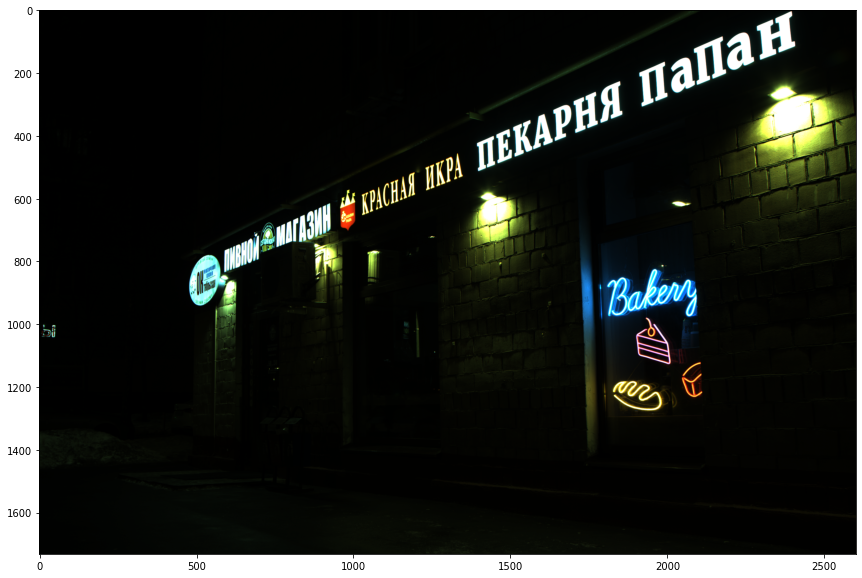

In [8]:
demosaic_image = pipeline_demo.demosaic(normalized_image, metadata)
plt.imshow(np.clip(demosaic_image, 0, 1))

## Denoising

/mnt/files/Projects/iitp/ntire/nightimaging23/demo/../raw_prc_pipeline/pipeline_utils.py:258: FutureWarning: `multichannel` is a deprecated argument name for `denoise_bilateral`. It will be removed in version 1.0. Please use `channel_axis` instead.
  current_image = denoise_bilateral(


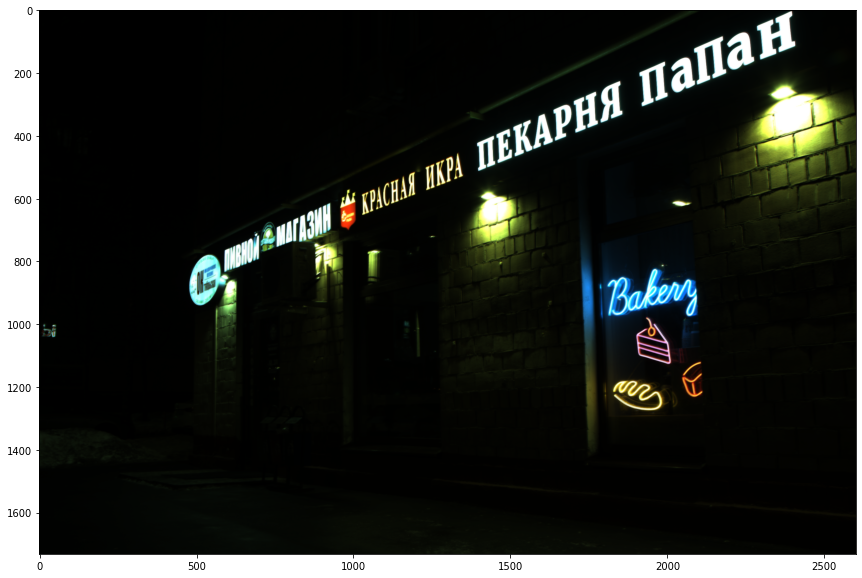

In [9]:
denoised_image = pipeline_demo.denoise(demosaic_image, metadata)
plt.imshow(np.clip(denoised_image, 0, 1))

##  Estimating illumination parameters and white balancing

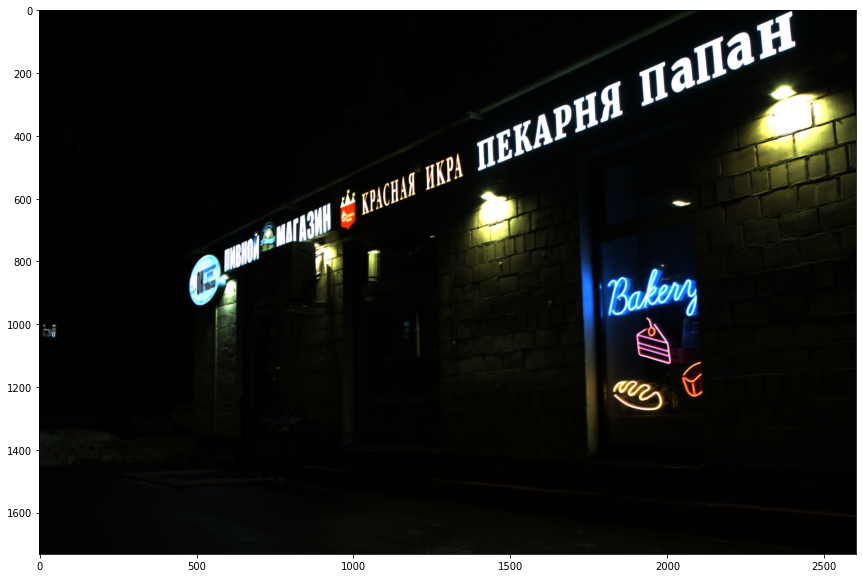

In [10]:
white_balanced_image = pipeline_demo.white_balance(denoised_image, metadata)
plt.imshow(white_balanced_image)

## Transforming to XYZ

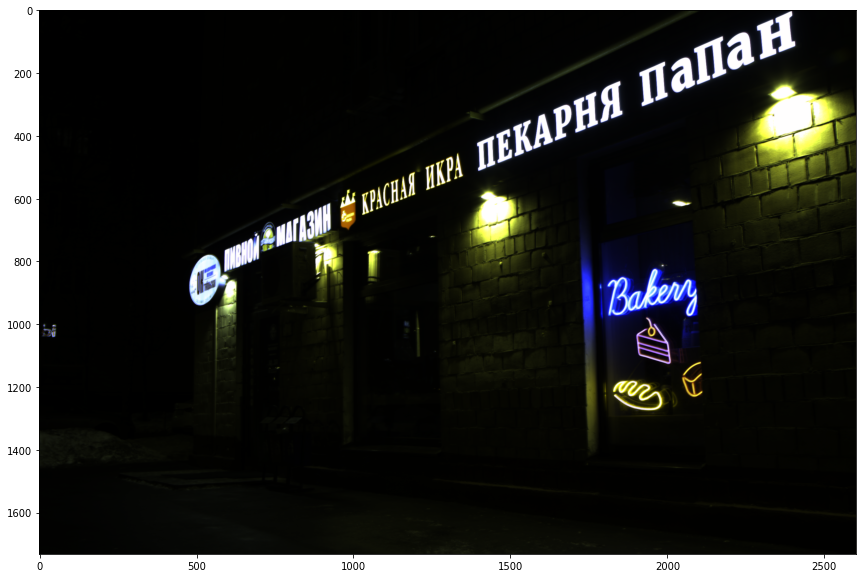

In [11]:
xyz_image = pipeline_demo.xyz_transform(white_balanced_image, metadata)
plt.imshow(xyz_image)

## Transforming to sRGB

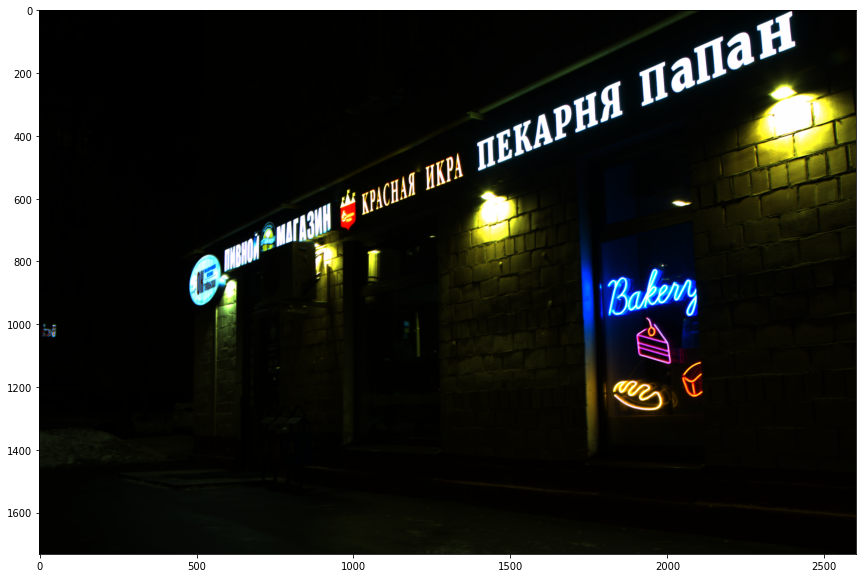

In [12]:
srgb_image = pipeline_demo.srgb_transform(xyz_image, metadata)
plt.imshow(srgb_image)

## Tone mapping

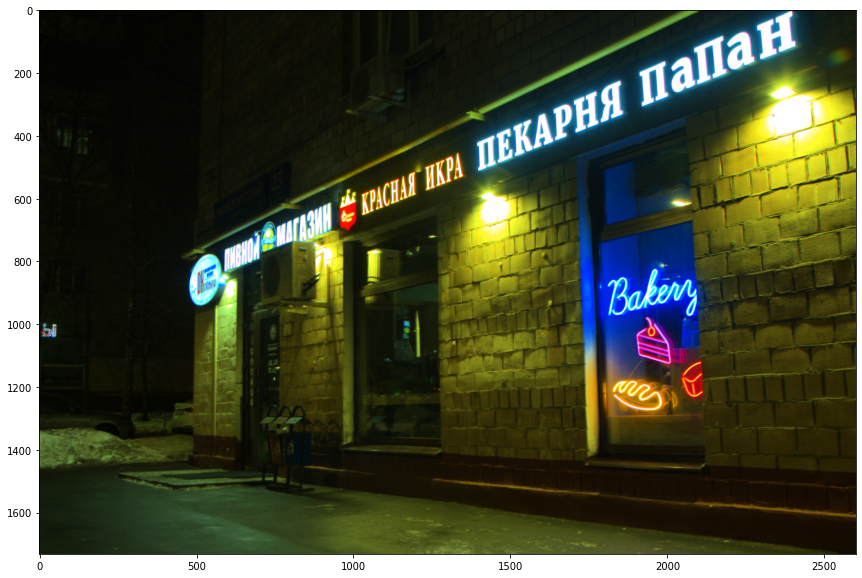

In [13]:
tone_image = pipeline_demo.tone_mapping(srgb_image, metadata)
plt.imshow(tone_image)

## Gamma correction

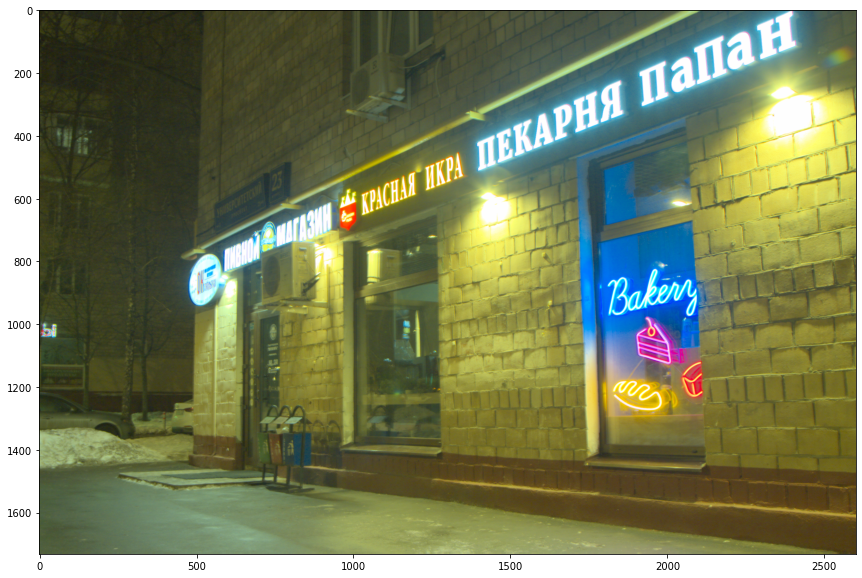

In [14]:
gamma_image = pipeline_demo.gamma_correct(tone_image, metadata)
plt.imshow(gamma_image)

## Autocontrast

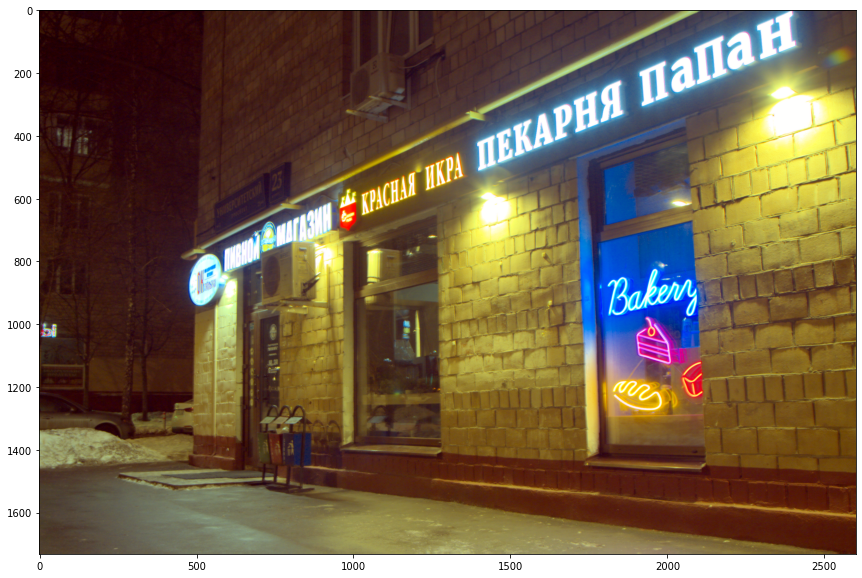

In [15]:
result_image_float = pipeline_demo.autocontrast(gamma_image, metadata)
plt.imshow(result_image_float)

## Converting to uint8

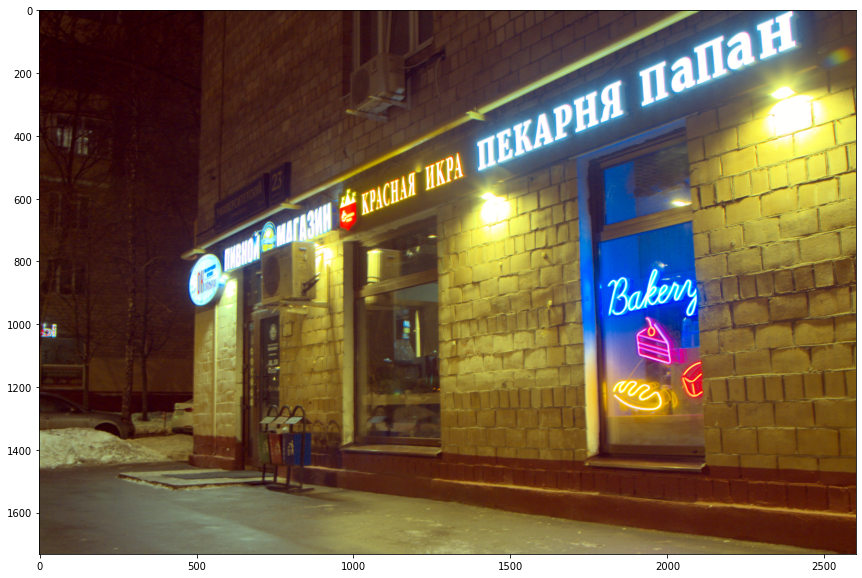

In [16]:
img_uint8 = pipeline_demo.to_uint8(result_image_float, metadata)
plt.imshow(img_uint8)

## Resizing

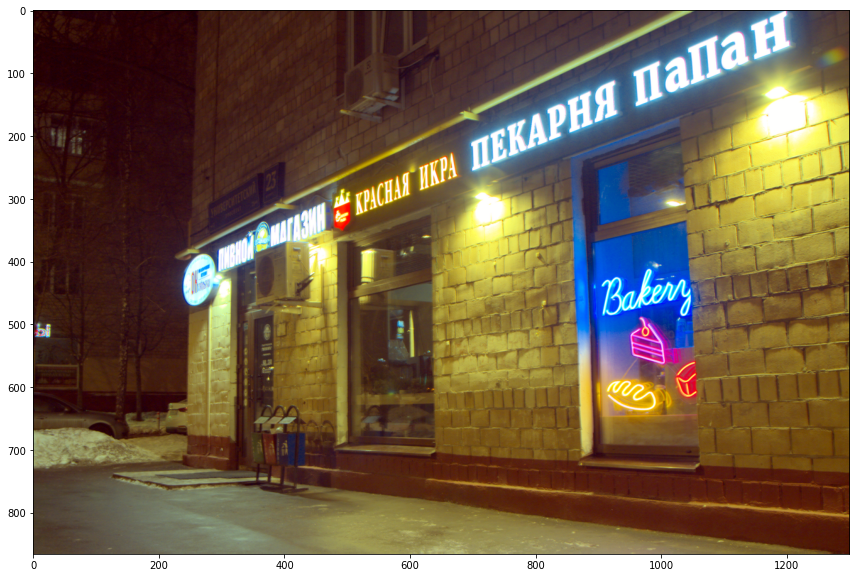

In [17]:
img_resized = pipeline_demo.resize(img_uint8, metadata)
plt.imshow(img_resized)

## Fixing image orientation

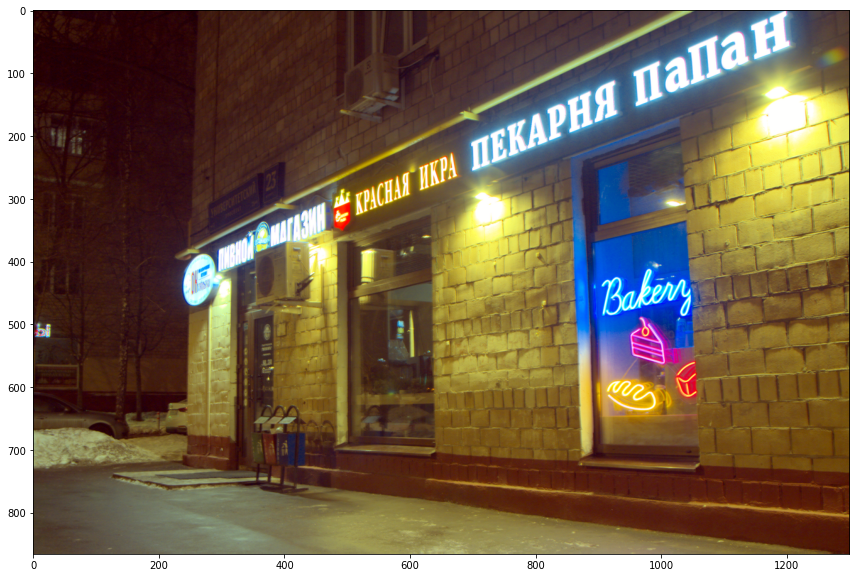

In [18]:
resulted_image = pipeline_demo.fix_orientation(img_resized, metadata)
plt.imshow(resulted_image)

## Processing image using PipelineExecutor

In [19]:
pipeline_exec = PipelineExecutor(raw_image, metadata, pipeline_demo)

image_from_executor = pipeline_exec()


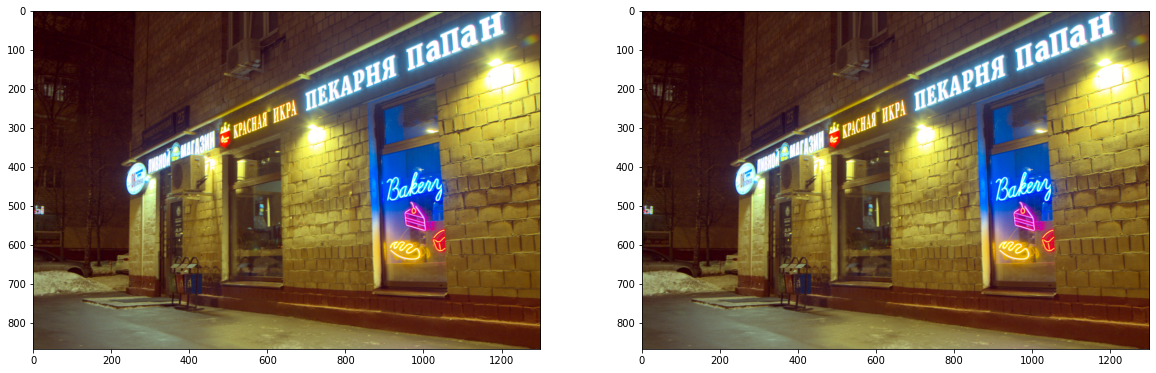

In [20]:
assert np.array_equal(resulted_image, image_from_executor)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(resulted_image)
ax2.imshow(image_from_executor)